<a href="https://colab.research.google.com/github/professor4044/NLP-Project/blob/main/NLPProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TASK : 1 : Load Python Libraries

In [50]:
import os, re, json, time, random, string, urllib.request
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

random.seed(42)
np.random.seed(42)

import sklearn, matplotlib


TASK : 2 : Load NLTK package

In [51]:
packages = [
    "punkt", "stopwords", "wordnet", "omw-1.4",
    "averaged_perceptron_tagger", "averaged_perceptron_tagger_eng",
    "punkt_tab"
]

for p in packages:
    try:
        nltk.download(p, quiet=True)
    except Exception as e:
        print(f"NLTK download failed for {p}: {e}")

STOP_WORDS = set(stopwords.words("english"))
stemmer = PorterStemmer()
wnl = WordNetLemmatizer()

print("NLTK done")


NLTK done


TASK : 3 :Load dataset

In [52]:
from datasets import load_dataset
import pandas as pd
from collections import Counter

dataset = load_dataset("csv", data_files="fake.csv", split="train[:10000]")

df = pd.DataFrame(dataset)

print(df.head(3))

print("Label distribution:", Counter(df["type"].tolist()))

print("Total rows:", len(df))


                                       uuid  ord_in_thread  \
0  6a175f46bcd24d39b3e962ad0f29936721db70db              0   
1  2bdc29d12605ef9cf3f09f9875040a7113be5d5b              0   
2  c70e149fdd53de5e61c29281100b9de0ed268bc3              0   

                 author                      published  \
0     Barracuda Brigade  2016-10-26T21:41:00.000+03:00   
1  reasoning with facts  2016-10-29T08:47:11.259+03:00   
2     Barracuda Brigade  2016-10-31T01:41:49.479+02:00   

                                               title  \
0  Muslims BUSTED: They Stole Millions In Gov’t B...   
1  Re: Why Did Attorney General Loretta Lynch Ple...   
2  BREAKING: Weiner Cooperating With FBI On Hilla...   

                                                text language  \
0  Print They should pay all the back all the mon...  english   
1  Why Did Attorney General Loretta Lynch Plead T...  english   
2  Red State : \nFox News Sunday reported this mo...  english   

                         crawled

TASK:4:Tokenization

In [53]:
from nltk.tokenize import word_tokenize

# ১. ফাংশন ডিফাইন করা (ছবির স্টাইলে)
def tokenize(column_data):
    return [word_tokenize(str(t)) for t in column_data]

# ২. শুধুমাত্র 'text' কলাম টোকেনাইজ করা
tokenized_text = tokenize(df['text'])

# ৩. আউটপুট দেখা (প্রথম নিউজের প্রথম ৩০টি টোকেন)
print(tokenized_text[0][:50])

['Print', 'They', 'should', 'pay', 'all', 'the', 'back', 'all', 'the', 'money', 'plus', 'interest', '.', 'The', 'entire', 'family', 'and', 'everyone', 'who', 'came', 'in', 'with', 'them', 'need', 'to', 'be', 'deported', 'asap', '.', 'Why', 'did', 'it', 'take', 'two', 'years', 'to', 'bust', 'them', '?', 'Here', 'we', 'go', 'again', '…another', 'group', 'stealing', 'from', 'the', 'government', 'and']


TASK:5:Case folding

In [54]:
from nltk.tokenize import word_tokenize

# ১. শুধু 'text' কলামটি টোকেনাইজ করে একটি লিস্টে রাখা
tokenized_text = [word_tokenize(str(news)) for news in df['text']]

# ২. আউটপুট দেখা (ছবির স্টাইলে - প্রথম খবরের প্রথম ৩০টি শব্দ)
print(tokenized_text[0][:30])

['Print', 'They', 'should', 'pay', 'all', 'the', 'back', 'all', 'the', 'money', 'plus', 'interest', '.', 'The', 'entire', 'family', 'and', 'everyone', 'who', 'came', 'in', 'with', 'them', 'need', 'to', 'be', 'deported', 'asap', '.', 'Why']


TASK:6:Punctuation Removal

In [55]:
import re

# ১. ফাংশন যা একবারে Punctuation এবং Special Character রিমুভ করবে
def clean_tokens(doc_tokens):
    clean_doc = []
    for token in doc_tokens:
        # শুধু a-z, A-Z এবং 0-9 রাখা হবে।
        # এর মানে Punctuation এবং Special Char সব অটোমেটিক মুছে যাবে।
        new_token = re.sub(r'[^a-zA-Z0-9]', '', token)

        # মুছতে মুছতে যদি শব্দটি ফাঁকা না হয়ে যায়, তবেই লিস্টে রাখা হবে
        if new_token != '':
            clean_doc.append(new_token)
    return clean_doc

# ২. আপনার টোকেনাইজড টেক্সটের ওপর এই ফাংশনটি চালানো
# (মনে রাখবেন: 'tokenized_text' হলো আপনার আগের ধাপে পাওয়া টোকেন লিস্ট)
final_cleaned_text = [clean_tokens(tokens) for tokens in tokenized_text]

# ৩. আউটপুট দেখা (প্রথম খবরের প্রথম ৩০টি ক্লিন টোকেন)
print(final_cleaned_text[0][:30])

['Print', 'They', 'should', 'pay', 'all', 'the', 'back', 'all', 'the', 'money', 'plus', 'interest', 'The', 'entire', 'family', 'and', 'everyone', 'who', 'came', 'in', 'with', 'them', 'need', 'to', 'be', 'deported', 'asap', 'Why', 'did', 'it']


TASK:7:Stop word removal

In [56]:
import nltk
from nltk.corpus import stopwords

# ১. স্টপওয়ার্ডস লোড করা
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ২. ফাংশন তৈরি
def remove_stopwords(tokens_list):
    # স্টপ ওয়ার্ড লিস্টে নেই এমন শব্দগুলোই শুধু রাখা হবে
    return [word for word in tokens_list if word not in stop_words]

# ৩. আপনার ক্লিন করা টেক্সটের ওপর এটি অ্যাপ্লাই করা
# (মনে রাখবেন: 'final_cleaned_text' হলো আপনার আগের ধাপের স্পেশাল ক্যারেক্টার রিমুভ করা লিস্ট)
text_without_stopwords = [remove_stopwords(tokens) for tokens in final_cleaned_text]

# ৪. আউটপুট দেখা (সরাসরি লিস্ট)
print(text_without_stopwords[0][:30])

['Print', 'They', 'pay', 'back', 'money', 'plus', 'interest', 'The', 'entire', 'family', 'everyone', 'came', 'need', 'deported', 'asap', 'Why', 'take', 'two', 'years', 'bust', 'Here', 'go', 'another', 'group', 'stealing', 'government', 'taxpayers', 'A', 'group', 'Somalis']


TASK:8:Lemmatization

In [57]:
import nltk
from nltk.stem import WordNetLemmatizer

# এই লাইনের শুরুতে # দিয়ে কমেন্ট করে দিন, কারণ এটি অলরেডি নামানো আছে
# nltk.download('wordnet')
# nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(token_list):
    return [lemmatizer.lemmatize(token) for token in token_list]

lemmatized_output = [lemmatize_text(tokens) for tokens in text_without_stopwords]

print(lemmatized_output[0][:30])

['Print', 'They', 'pay', 'back', 'money', 'plus', 'interest', 'The', 'entire', 'family', 'everyone', 'came', 'need', 'deported', 'asap', 'Why', 'take', 'two', 'year', 'bust', 'Here', 'go', 'another', 'group', 'stealing', 'government', 'taxpayer', 'A', 'group', 'Somalis']


TASK:9:Synonym Substitution

In [58]:
import nltk
from nltk.corpus import wordnet

# ১. ছবির মেথড অনুযায়ী ফাংশন তৈরি
def synonym_substitution(tokens_list):
    new_sentence = []

    for word in tokens_list:
        synonyms = wordnet.synsets(word)

        # যদি শব্দটির কোনো সিনোনিম বা সমার্থক শব্দ ডিকশনারিতে পাওয়া যায়
        if synonyms:
            # প্রথম সিনোনিমটি খুঁজে বের করা (এটিই হবে আমাদের replacement_word)
            new_word = synonyms[0].lemmas()[0].name()

            # যদি সিনোনিমটি মূল শব্দের চেয়ে আলাদা হয় এবং এতে কোনো আন্ডারস্কোর (_) না থাকে
            if new_word != word and "_" not in new_word:
                new_sentence.append(new_word) # রিপ্লেস করা হলো
            else:
                new_sentence.append(word)     # আগেরটাই রাখা হলো
        else:
            new_sentence.append(word)         # সিনোনিম না পেলে যা ছিল তাই থাকবে

    return new_sentence

# ২. আপনার লেমাটাইজড ডাটার ওপর এটি চালানো
# 'lemmatized_output' হলো আপনার আগের ধাপের ডাটা
synonym_replaced_data = [synonym_substitution(tokens) for tokens in lemmatized_output]

# ৩. আউটপুট দেখা
print(synonym_replaced_data[0][:30])

['print', 'They', 'wage', 'back', 'money', 'asset', 'interest', 'The', 'stallion', 'family', 'everyone', 'come', 'need', 'behave', 'ASAP', 'why', 'return', 'two', 'year', 'flop', 'here', 'go', 'another', 'group', 'larceny', 'government', 'taxpayer', 'angstrom', 'group', 'Somalian']


TASK:10:Split (Train , Test/Validation)

In [59]:
from sklearn.model_selection import train_test_split

# ১. টোকেনগুলোকে জোড়া লাগিয়ে আবার বাক্যে রূপান্তর করা
# 'synonym_replaced_data' হলো আপনার সর্বশেষ প্রসেস করা ডেটা
X_text = [" ".join(tokens) for tokens in synonym_replaced_data]

# ২. ফিচার এবং লেবেল ঠিক করা
X = X_text
y = df['type']

# ৩. Train-Test Split (৮০% ট্রেনিং, ২০% টেস্টিং)
# test_size=0.2 মানে ২০% ডেটা পরীক্ষার জন্য
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ৪. রেজাল্ট দেখা
print("Total Data:", len(X))
print("Training Data Size (80%):", len(X_train))
print("Testing Data Size (20%):", len(X_test))

Total Data: 10000
Training Data Size (80%): 8000
Testing Data Size (20%): 2000


TASK:11:Using TF-IDF

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

# ১. min_df=5 : যে শব্দটি অন্তত ৫টি আলাদা নিউজে আসেনি, সেটি বাদ যাবে (Typo বা ফালতু শব্দ কমে যাবে)
# ২. ngram_range=(1, 3) : এখনো ১-৩ শব্দের জোড়া রাখা হলো যাতে কনটেক্সট থাকে
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=5)

# ৩. Training Data-র ওপর fit এবং transform করা
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# ৪. Testing Data-র ওপর transform করা
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# ৫. আউটপুট চেক করা
print("Training Data Shape:", X_train_tfidf.shape)
print("Testing Data Shape:", X_test_tfidf.shape)

Training Data Shape: (8000, 129206)
Testing Data Shape: (2000, 129206)


TASK:12:Applying Naïve Bayes Algorithm

In [61]:
from sklearn.naive_bayes import MultinomialNB

# ১. মডেল তৈরি করা
nb_model = MultinomialNB()

# ২. ট্রেনিং ডেটা দিয়ে মডেল ট্রেইন করা
nb_model.fit(X_train_tfidf, y_train)

# ৩. টেস্ট ডেটা দিয়ে প্রেডিকশন করা
y_pred = nb_model.predict(X_test_tfidf)

# ৪. আউটপুট (আপনার চাওয়া অনুযায়ী শুধু মেসেজ)
print("Naive Bayes algorithm has been applied successfully.")

Naive Bayes algorithm has been applied successfully.


TASK:13:Confusion matrix & Curve (ROC, AUC)

Accuracy:  0.8082
Precision: 0.7895
Recall:    0.8333
F1-score:  0.8108

Classification report:

              precision    recall  f1-score   support

    Real (0)       0.83      0.78      0.81        74
    Fake (1)       0.79      0.83      0.81        72

    accuracy                           0.81       146
   macro avg       0.81      0.81      0.81       146
weighted avg       0.81      0.81      0.81       146



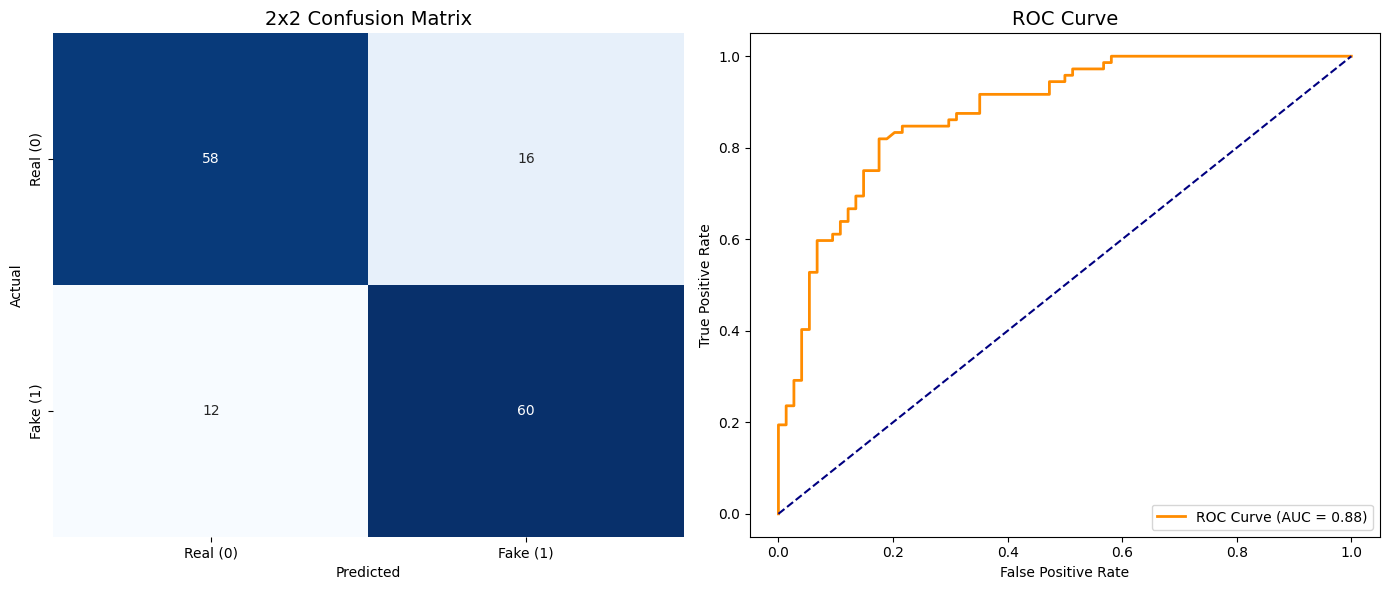

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             roc_curve, roc_auc_score)

# ==============================================================================
# ১. ডেটা প্রসেসিং (সাইলেন্ট মোড)
# ==============================================================================
text_col = 'text'  # আপনার কলামের নাম 'content' হলে এটি পরিবর্তন করুন
df[text_col] = df[text_col].fillna('')
df[text_col] = df[text_col].astype(str)

label_mapping = {
    'fake': 1, 'conspiracy': 1, 'bs': 1, 'junksci': 1, 'satire': 1, 'hate': 1,
    'bias': 0, 'state': 0
}

if df['type'].dtype == object:
    df['binary_type'] = df['type'].map(label_mapping)
else:
    df['binary_type'] = df['type']

df = df.dropna(subset=['binary_type'])
df['binary_type'] = df['binary_type'].astype(int)

# ডেটা ব্যালেন্সিং
df_0 = df[df['binary_type'] == 0]
df_1 = df[df['binary_type'] == 1]
min_len = min(len(df_0), len(df_1))

df_balanced = pd.concat([
    df_0.sample(min_len, random_state=42),
    df_1.sample(min_len, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

# ==============================================================================
# ২. ট্রেইনিং
# ==============================================================================
X = df_balanced[text_col]
y = df_balanced['binary_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 3), min_df=5)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# ==============================================================================
# ৩. আউটপুট (শুধুমাত্র রেজাল্ট এবং গ্রাফ)
# ==============================================================================
y_pred = nb_model.predict(X_test_vec)
y_proba = nb_model.predict_proba(X_test_vec)[:, 1]

# শুধু মেট্রিক্স প্রিন্ট হবে
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=['Real (0)', 'Fake (1)']))

# গ্রাফ
plt.figure(figsize=(14, 6))

# Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'])
plt.title('2x2 Confusion Matrix', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC
plt.subplot(1, 2, 2)
auc_score = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.legend(loc="lower right")
plt.title('ROC Curve', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
plt.show()